# Edge detection via 2D convolution

In section 10.3.2, we discussed how to detect edges in images via 2D convolution. This notebook contains the fully functional code for the same.

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def load_grayscale_image(img_path):
    """
    Takes an image path, reads the image as a gray scale image and converts
    the resulting image to a tensor
    """
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

def img_to_tensor(img):
    """
    Takes a numpy array corresponding to an image and converts it to a Pytorch tensor
    """
    return torch.from_numpy(img).float()

def tensor_to_img(x):
    """
    Takes a tensor, does min-max normalization to scale the tensor to a value between 0 and 255
    and returns the resulting numpy array
    """
    x_norm = ((x - x.min()) / (x.max() - x.min())) * 255
    return x_norm.to(torch.uint8).numpy()

First, let us load a sample image to detect edges on. As you can see in the image of the rubiks cube displayed below, there are both vertical and horizontal edges that need to be detected. We will have separate kernels for each of these cases. Let us first start with vertical edge detection.

In [3]:
img = load_grayscale_image("Figures/rubiks_grey.png")

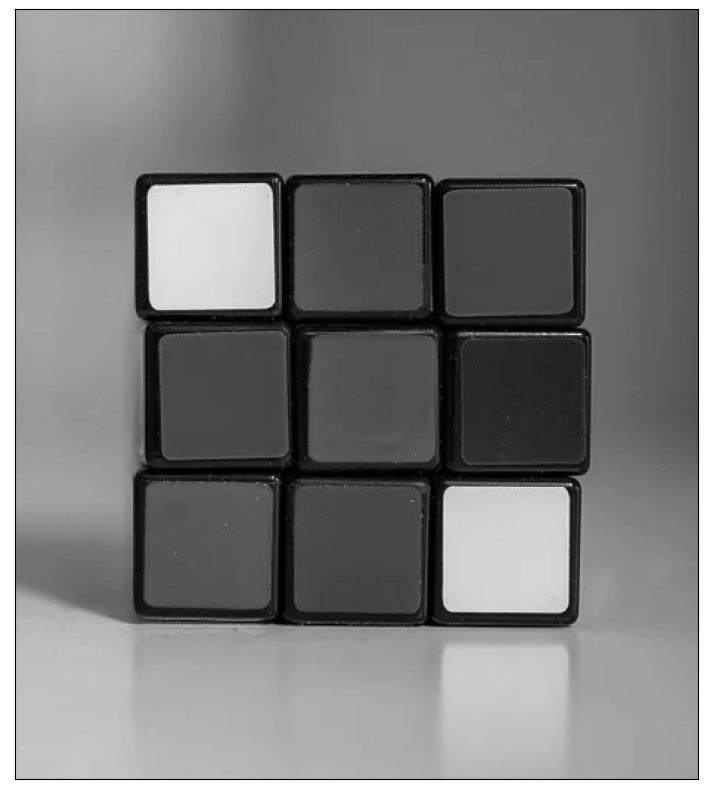

In [4]:
# Let us take a look at the image and plot it
fig = plt.figure(figsize = (10, 10)) 
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(img.astype(np.float32) / 255.0, cmap="gray")

In [5]:
img_tensor = img_to_tensor(img)

The vertical edge detection kernel is a 2x2 kernel with +1 on one side and -1 on the other side, i.e.
$$
\begin{bmatrix}
-1 & 1 \\
-1 & 1 \\
\end{bmatrix}
$$

When there is a vertical edge in the input image, we expect to find high values on one side of the edge and low values on the other side. Thus multiplying with the above kernel would result in a high value (positive or negative depending on which side has higher values in the input image) in the output image. On the other hand, if we have a smooth input image, the output value would be close to 0 because positive and negative values will cancel out.

In [6]:
# Define the vertical edge detection kernel
vertical_edge_kernel = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float32)
# Conv 2D kernels need to be of shape (out_channel, in_channel, k_x, k_y). Since we are defining a single kernel
# out_channel = in_channel = 1. So we unsqueeze to add those extra dimensions
vertical_edge_kernel = vertical_edge_kernel.unsqueeze(0).unsqueeze(0) 
vertical_edge_kernel = vertical_edge_kernel/ 4
print(f"Kernel shape {vertical_edge_kernel.shape}\nKernel: {vertical_edge_kernel}")  # 1x1x3x3
vertical_edge_weight = nn.Parameter(data=vertical_edge_kernel, requires_grad=False)

Kernel shape torch.Size([1, 1, 2, 2])
Kernel: tensor([[[[-0.2500,  0.2500],
          [-0.2500,  0.2500]]]])


In [7]:
# Let us convolve the edge detection kernel over the input image. 
# This can be done in 2 ways. 

# 2-D Convolution operations work on 4D tensors of the form (N, C, H, W).
# Let us convert out tensor to this format
img_batch = img_tensor.unsqueeze(0).unsqueeze(0)

# 1) Using conv2d function
out_tensor_1 = F.conv2d(img_batch, vertical_edge_weight, padding=0)

# 2) Using Conv2d layer
conv2d = nn.Conv2d(1, 1, kernel_size=[2, 2], stride=1, padding=0, bias=False)
conv2d.weight = vertical_edge_weight
with torch.no_grad():
    out_tensor_2 = conv2d(img_batch)

In [8]:
# Let us assert both the ways yielded the same result
assert torch.allclose(out_tensor_1, out_tensor_2)

In [9]:
out_tensor = out_tensor_1[0][0] 
img = tensor_to_img(out_tensor)

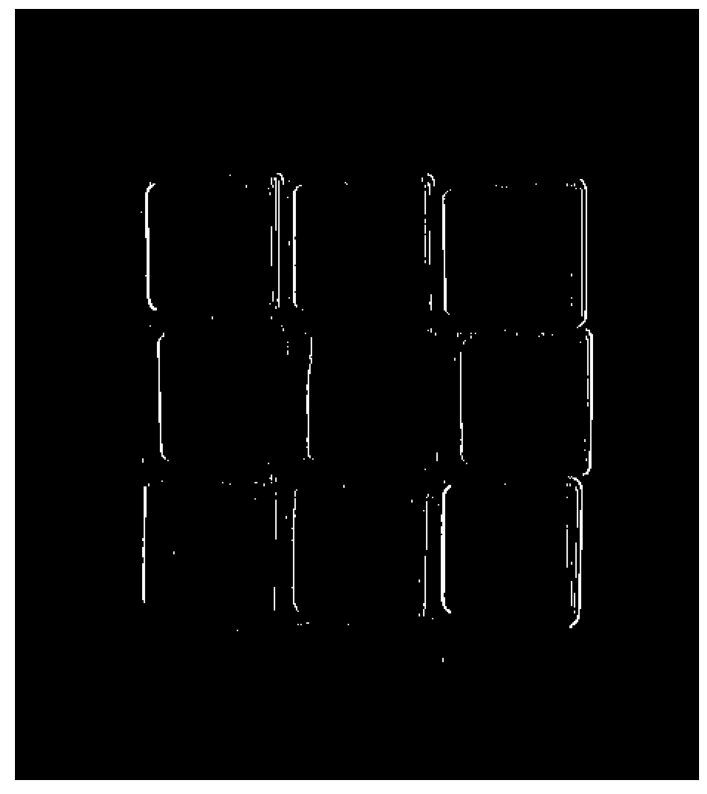

In [10]:
# Let us take a look at the image and plot it
# Let us do some thresholding to plot the edges more distinctly
ret, thresh_img = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize = (10, 10)) 
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(thresh_img, cmap="gray")

The horizontal edge detection kernel is very similar to the vertical edge detection kernel, except with rows and columsn interchanged. Essentially, it is the transpose of the vertical edge detection kernel, i.e.
$$
\begin{bmatrix}
-1 & -1 \\
1 & 1 \\
\end{bmatrix}
$$

In [11]:
# Define the horizonatal edge detection kernel
horizontal_edge_kernel = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float32)
# Conv 2D kernels need to be of shape (out_channel, in_channel, k_x, k_y). Since we are defining a single kernel
# out_channel = in_channel = 1. So we unsqueeze to add those extra dimensions
horizontal_edge_kernel = horizontal_edge_kernel.unsqueeze(0).unsqueeze(0) 
horizontal_edge_kernel = horizontal_edge_kernel/ 4
print(f"Kernel shape {horizontal_edge_kernel.shape}\nKernel: {horizontal_edge_kernel}")  # 1x1x3x3
horizontal_edge_weight = nn.Parameter(data=horizontal_edge_kernel, requires_grad=False)

Kernel shape torch.Size([1, 1, 2, 2])
Kernel: tensor([[[[-0.2500, -0.2500],
          [ 0.2500,  0.2500]]]])


In [12]:
out_tensor_1 = F.conv2d(img_batch, horizontal_edge_weight, padding=1)
img_tensor = out_tensor_1[0][0] 
img = tensor_to_img(img_tensor)

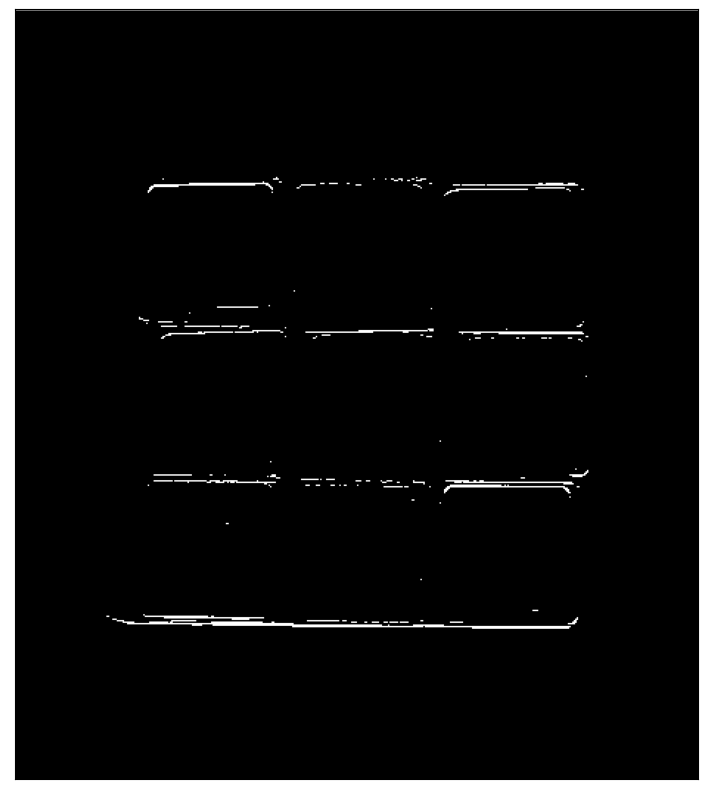

In [13]:
ret, thresh_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize = (10, 10)) 
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(thresh_img, cmap="gray")